## CMSC 320 Final Project
### Predicting the Salaries of NBA Players
Nish Gowda

### Outline
1. Introduction
2. Data Processing
    1. Importing Libraries
    2. Data Wrangling
    3. Tidying up data
3. Exploratory Data Analysis and Visualization
    1. Exploring the Data
    2. Data Visualizations
    3. Further Analysis
4. Machine Learning & Predictions
    1. Data Preparation
    2. Model Building and Training
5. Conclusion
6. References

## 1. Introduction

Like it or not statistcs has changed the NBA forever. Data analytics has changed the way teams approach strategy, player value, and has blown player and team stats into historic numbers. 
In this tutorial, I want to analyze the correlation of a player's statistics with their salaries and ues machine learning to create a model that can make predictions of a player's salary based on their stats.

## 2. Data Processing

### 2.1 Importing Libraries

In [148]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

### 2.2 Data Wrangling

[Basketball Reference](https://www.basketball-reference.com/) is a great website that has all the data we need for this. Using beautiful soup and pandas, we can scrape all the data from site and create a dataframe with it. The stats we'll look at in particular are the standard box score stats like points, rebounds, assists but also "advanced" stats like true shooting, winshares, and box plus minus.

In [149]:
def scrape_nba_player_stats(year):
    url = f'https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html'
    table = pd.read_html(url)

    cols = ['Player', 'Tm', 'G', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', '3P', 'FG%', '3P%', 'FT%']
    basic_df = table[0]
    basic_df = basic_df[cols]
    for col in cols:
        basic_df = basic_df[basic_df[col] != str(col)]
    cols = basic_df.select_dtypes(include=[np.object]).columns
    basic_df[cols] = basic_df[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
    basic_df = basic_df.replace(r'^\s*$', np.NaN, regex=True)
    basic_df = basic_df.fillna(0.0)
    for col in cols[2:]:
        basic_df[col] = basic_df[col].astype(float)

    url = f'https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html'
    table = pd.read_html(url)
    adv_df = table[0]

    adv_df = adv_df[['Player', 'WS', 'BPM', 'VORP', 'TS%', 'PER']]
    adv_df = adv_df[adv_df.Player != 'Player']
    adv_df = adv_df[adv_df.WS != 'WS']
    adv_df = adv_df[adv_df.BPM != 'BPM']
    adv_df = adv_df[adv_df.VORP != 'VORP']
    adv_df = adv_df[adv_df.PER != 'PER']
    adv_df = adv_df[adv_df['TS%'] != 'TS%']

    cols = adv_df.select_dtypes(include=[np.object]).columns
    adv_df[cols] = adv_df[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
    adv_df['WS'] = adv_df['WS'].astype(float)
    adv_df['BPM'] = adv_df['BPM'].astype(float)
    adv_df['VORP'] = adv_df['VORP'].astype(float)
    adv_df['TS%'] = adv_df['TS%'].astype(float)
    adv_df['PER'] = adv_df['PER'].astype(float)
    
    df = pd.merge(basic_df, adv_df, how="inner", on="Player")
    df = df.drop_duplicates(subset=['Player'], keep='first')

    return df

This function creates a dataframe for us that combines a players standard and advanced stats on a per game basis. Now, we need to get data on a player's salary and what the salary cap was for a given year. Basketball Reference gives the html code for their data on their [salary cap history page](https://www.basketball-reference.com/contracts/salary-cap-history.html). I've just copied this into it's own html file.

In [150]:
def get_salary_cap(year):
    with open('salary_cap_data.html', 'r') as f:
        page = f.read()
        soup = BeautifulSoup(page, "html.parser")
        rows = soup.findAll('tr')
        rows_data = [[td.getText().strip().replace("$", "").replace(",", "") for td in rows[i].findAll('td')]
                            for i in range(len(rows))]
        year_to_grab = 2022 - year
        return float(rows_data[(len(rows_data) - 1) - year_to_grab][0])
                


Now we want a function we can call that will get the salary of a player for a specific year and then call our salary cap function to create a salary_per_cap column that tells us what portion of the salary cap a player's contract was valued at.

We'll be using [hoopshype](https://hoopshype.com/salaries/players/) to get this information via web scraping with beautiful soup.

In [154]:
def scrape_player_salaries(year):
    url = ''
    s = ''
    if year == 2022:
        url = 'https://hoopshype.com/salaries/players/'
        s = '2021/22'
    else:
        url = f'https://hoopshype.com/salaries/players/{year-1}-{year}/'
        s = f'{year-1}/{str(year)[2:]}'
    try:
        table = pd.read_html(url)
        df = table[0]
        df = df[['Player', s]]
        # get rid of empty slots in the data
        df = df.replace(r'^\s*$', 0, regex=True)
        df = df.rename(columns={s:"Salary"})
        # Lets get rid of any dollar signs and commas
        df['Salary'] = df['Salary'].str.replace(',', '').str.replace('$', '').astype(float)
        df = df.dropna()
        df = df.drop_duplicates()
        salary_cap = get_salary_cap(year)
        df['salary_cap'] = salary_cap
        df['salary_per_cap'] = df['Salary'] / salary_cap 
        return df
    except:
        return
        


### 2.3 Tidying up the  data

Now that we have functions to create two different dataframes for player stats and salaries, we'll be combine that information into one dataframe for each year from 2015 to 2022.

In [156]:
years = [yr for yr in range(2015, 2023)]
dfs = []
for year in years:
    try:
        stats_df = scrape_nba_player_stats(year)
        salary_df = scrape_player_salaries(year)
        df = pd.merge(salary_df, stats_df, how="inner", on="Player")
        df['Year'] = str(year).strip()
        #print(df)
        max_games = df["G"].max()
        df = df.drop(df[df['G'] < 0.3 * max_games].index)    
        dfs.append(df)
    except:
        continue

Let's combine all the dataframes into one bigger one now.

In [157]:
df = pd.concat(dfs)

## 3. Exploratory Data Analysis & Visualization

### 3.1 Exploring the data

First, we need to start this process by looking at the stats we've scraped and deciding on the best approach to predict how much a player should earn

In [159]:
df

Player      Salary   salary_cap  salary_per_cap   Tm     G  \
0          Joe Johnson  23180790.0   63065000.0        0.367570  BRK  80.0   
1      Carmelo Anthony  22458401.0   63065000.0        0.356115  NYK  40.0   
2        Dwight Howard  21436271.0   63065000.0        0.339908  HOU  41.0   
3         LeBron James  20644400.0   63065000.0        0.327351  CLE  69.0   
4           Chris Paul  20068563.0   63065000.0        0.318220  LAC  82.0   
..                 ...         ...          ...             ...  ...   ...   
423   Ignas Brazdeikis    462629.0  112414000.0        0.004115  ORL  13.0   
431  Justin Champagnie    462629.0  112414000.0        0.004115  TOR  15.0   
434      Trent Forrest    462629.0  112414000.0        0.004115  UTA  22.0   
437      Mychal Mulder    444017.0  112414000.0        0.003950  ORL  15.0   
442    Justin Robinson    170023.0  112414000.0        0.001512  TOT  18.0   

      PTS   TRB   AST  STL  ...   3P    FG%    3P%    FT%    WS  BPM  VORP  \
0    14.4   4.8   3.7  0.7  ...  1.5  0.435  0.359  0.801   4.1 -0.1   1.3   
1    24.2   6.6   3.1  1.0  ...  1.5  0.444  0.341  0.797   2.9  3.0   1.8   
2    15.8  10.5   1.2  0.7  ...  0.0  0.593  0.500  0.528   3.6 -0.4   0.5   
3    25.3   6.0   7.4  1.6  ...  1.7  0.488  0.354  0.710  10.4  7.1   5.7   
4    19.1   4.6  10.2  1.9  ...  1.7  0.485  0.398  0.900  16.1  8.0   7.2   
..    ...   ...   ...  ...  ...  ...    ...    ...    ...   ...  ...   ...   
423   1.8   1.4   0.5  0.2  ...  0.2  0.258  0.167  0.833  -0.1 -8.6  -0.2   
431   2.2   1.4   0.1  0.1  ...  0.0  0.400  0.000  1.000   0.2 -6.5  -0.1   
434   1.4   1.1   0.7  0.2  ...  0.0  0.524  0.333  0.800   0.3 -2.6   0.0   
437   3.7   1.4   0.2  0.3  ...  0.9  0.299  0.283  1.000  -0.4 -9.0  -0.3   
442   2.7   0.7   1.2  0.4  ...  0.6  0.310  0.270  1.000  -0.1 -7.8  -0.3   

       TS%   PER  Year  
0    0.523  14.1  2015  
1    0.531  21.5  2015  
2    0.596  19.2  2015  
3    0.577  25.9  2015  
4    0.596  26.0  2015  
..     ...   ...   ...  
423  0.357   3.7  2022  
431  0.486  11.8  2022  
434  0.610   8.5  2022  
437  0.405   2.5  2022  
442  0.408   4.2  2022  

[2593 rows x 22 columns]

Lets first look at how the average salaries have changed from 2015 to 2022.

[]

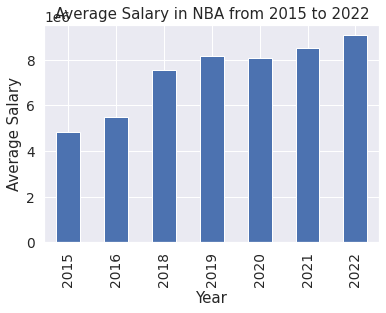

In [160]:
# Use the average NBA Salary from each year
sal=df.groupby('Year')['Salary'].mean()
var=sal.plot.bar(x='Year', y='Salary')
var.set_ylabel("Average Salary")
var.set_title("Average Salary in NBA from 2015 to 2022")
var.plot()

So, we can see that the average salary has been generally increasing each year since 2015, however there is a slight tick down in 2020 and 2021. There's an obvious guess as to why this is the case, but let's take a look at how the salary cap has changed over those years to get a better understanding of this.

[]

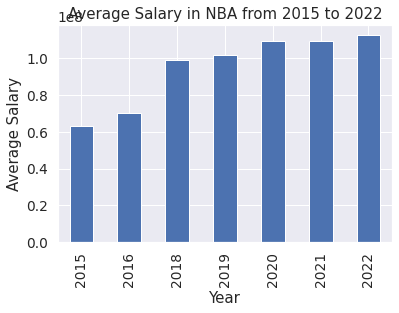

In [161]:
sal=df.groupby('Year')['salary_cap'].mean()
var=sal.plot.bar(x='Year', y='Salary')
var.set_ylabel("Average Salary")
var.set_title("Average Salary in NBA from 2015 to 2022")
var.plot()

So, we can see that in the 2020 and 2021, the salaray cap stagnated and didn't move. The most likley reasoning is becuase of COVID. See [here](https://www.nba.com/news/nba-and-nbpa-reach-agreement-salary-during-pandemic) for more information on this.

Because of the generall increase in salary over the years, it's better for us to pay more attention to a player's salary as a percentage of the salary cap. We'll use this metric as the basis for what we want to predict later.

### 3.2 Data Visualizations

#### Let's now look for any correlations between all statistics baring salary.

<AxesSubplot:>

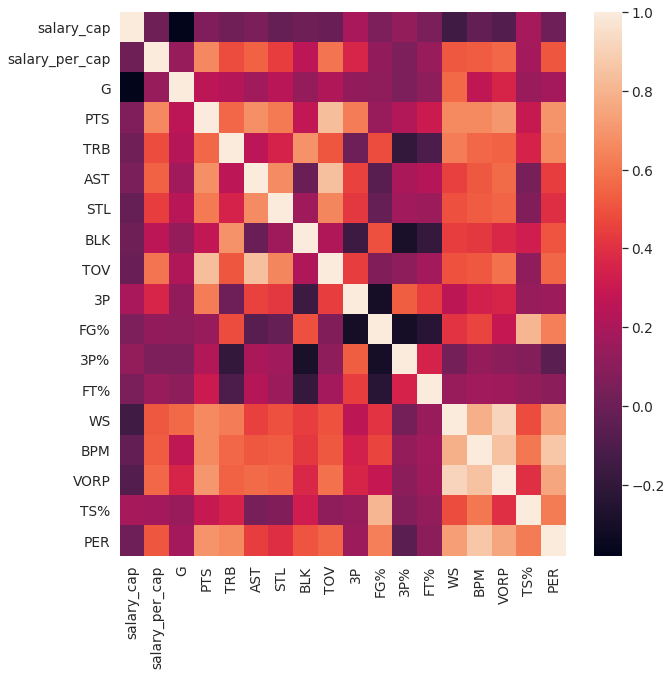

In [162]:
salary=df['Salary']
stats=df.drop(['Salary', 'Tm'], axis=1)

# setting up a heatmap for correlations between all statistics
fig, ax = plt.subplots(figsize=(10,10))
corr = stats.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, ax=ax)

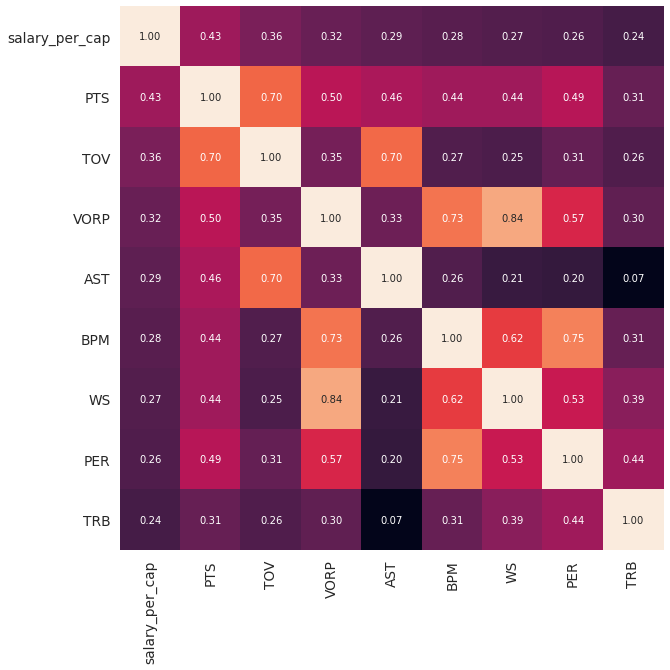

In [163]:
k = 9
corrmat = stats.corr(method='pearson', min_periods=1)
r_square = corrmat ** 2

## Top K-1 correlated variables
cols = r_square.nlargest(k, 'salary_per_cap')['salary_per_cap'].index
cm = stats[cols].corr()
cm_square = cm ** 2
f, ax = plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm_square, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

These heatmaps give use a great look at the correlation between stats with salary. What's interesting is how a lot of the advanced stats have a big correlation in particular. We'll revisit this later.

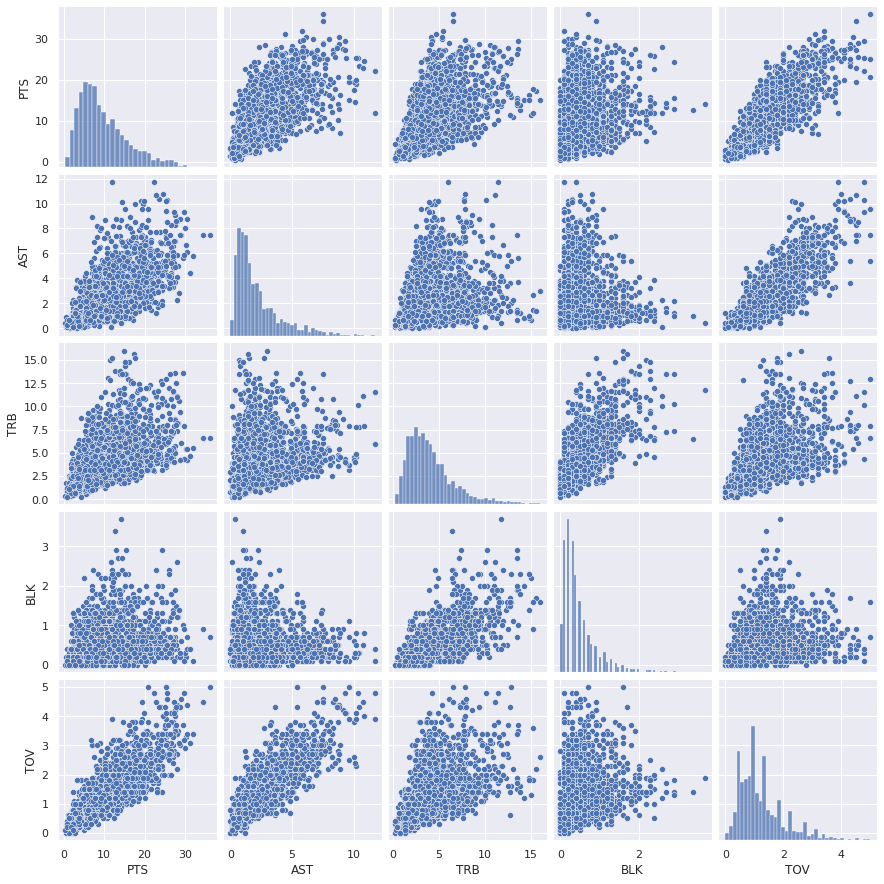

In [164]:
basic_stats = df[['PTS', 'AST', 'TRB', 'BLK', 'TOV']]
sns.set()
sns.pairplot(basic_stats, height=2.5)
plt.show()

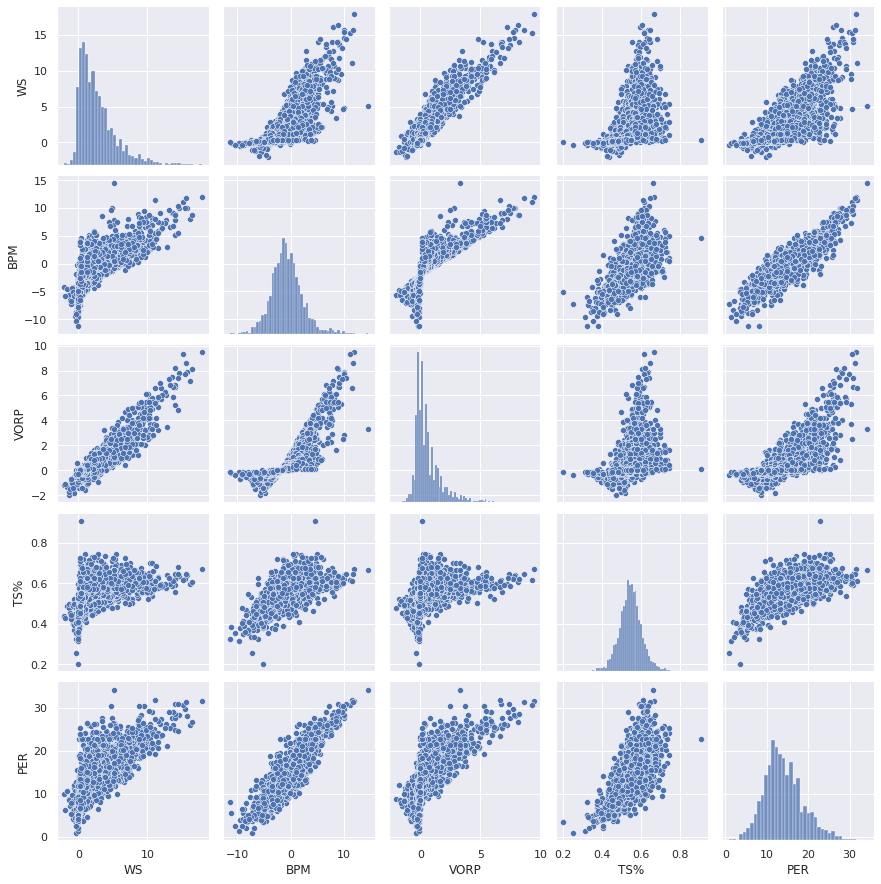

In [165]:
adv_stats = df[['WS', 'BPM', 'VORP', 'TS%', 'PER']]
sns.set()
sns.pairplot(adv_stats, height=2.5)
plt.show()

### 3.3 Further Analysis

Now that we have all the data, we need to come up with a way to determine how valuable a player is to their team. 

I think it's important that we seperate these stats into their own categories. First, we'll look at "box score stats" like Points, Assists, Rebounds, and Steals as they are what most fans of the sport look to see how good a player is.

Next, we'll try to see how efficient a player is. Seeing how effecient a player is by using stats like FG%, TS%, 3P% and PER are good tools for us to see the bigger picture behind a player's standard box score stats.

Finally, we'll look even further into the advanced stats like Win Shares, Box Plus Minus, and Value over Replacement Player. These will measure the 'effect' a player has on the court when they're playing. 

#### Box Score Stats

Lets look for a correlation between these boxscore stats and salary per salary cap.

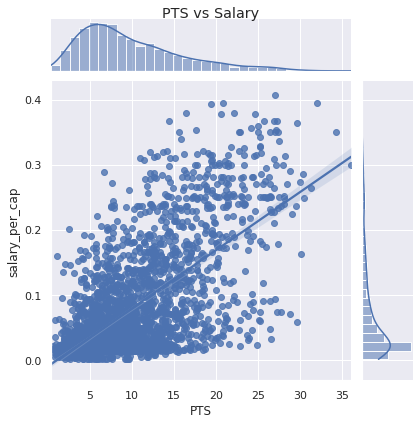

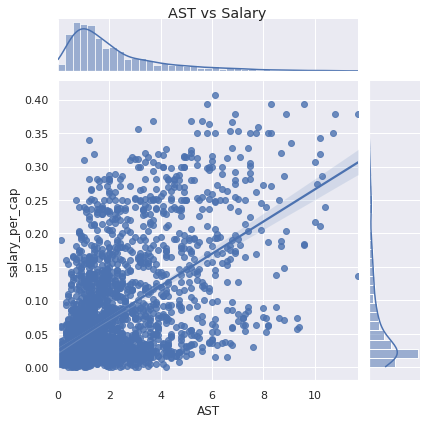

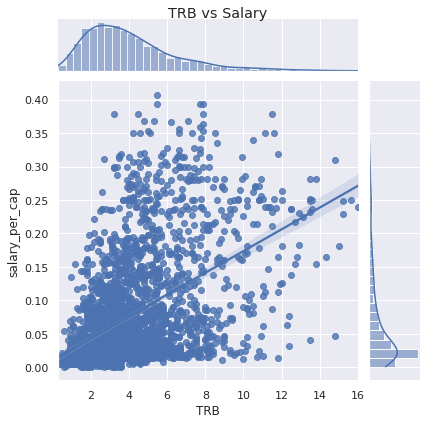

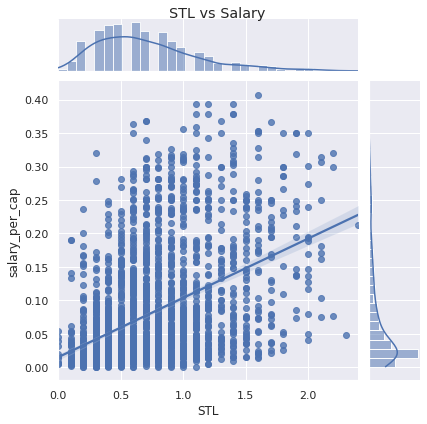

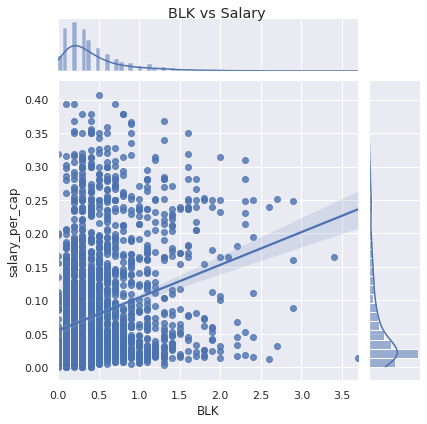

In [166]:
p = sns.jointplot(x='PTS',y='salary_per_cap', kind="reg", data=df );
p.fig.suptitle("PTS vs Salary")
p.fig.subplots_adjust(top=0.95) 


p = sns.jointplot(x='AST',y='salary_per_cap', kind="reg", data=df );
p.fig.suptitle("AST vs Salary")
p.fig.subplots_adjust(top=0.95) 


p = sns.jointplot(x='TRB',y='salary_per_cap', kind="reg", data=df );
p.fig.suptitle("TRB vs Salary")
p.fig.subplots_adjust(top=0.95) 


p = sns.jointplot(x='STL',y='salary_per_cap', kind="reg", data=df );
p.fig.suptitle("STL vs Salary")
p.fig.subplots_adjust(top=0.95) 

p = sns.jointplot(x='BLK',y='salary_per_cap', kind="reg", data=df );
p.fig.suptitle("BLK vs Salary")
p.fig.subplots_adjust(top=0.95) 

We can see from the plots that there is a pretty good corellation between points and salary per salary cap as well as assists and salary per salary cap as there's a general trend to the upper right for each plot. However, we can also notice that there isn't so much for rebounds and not much of a correlation at all for blocks and steals.

#### Efficiency

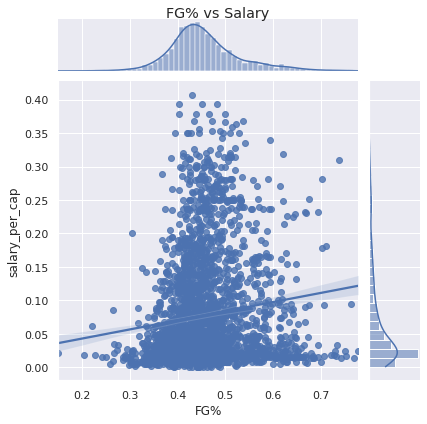

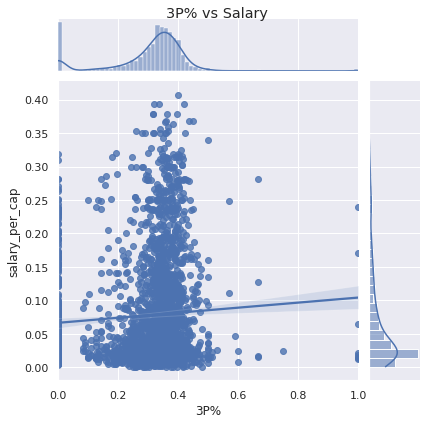

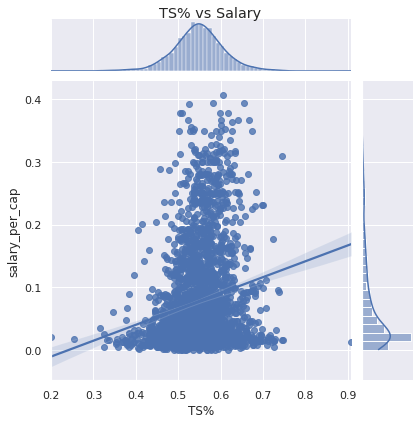

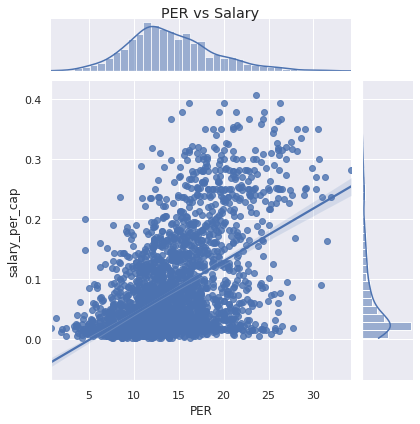

In [167]:
p = sns.jointplot(x='FG%',y='salary_per_cap', kind="reg", data=df );
p.fig.suptitle("FG% vs Salary")
p.fig.subplots_adjust(top=0.95)

p = sns.jointplot(x='3P%',y='salary_per_cap', kind="reg", data=df );
p.fig.suptitle("3P% vs Salary")
p.fig.subplots_adjust(top=0.95)

p = sns.jointplot(x='TS%',y='salary_per_cap', kind="reg", data=df );
p.fig.suptitle("TS% vs Salary")
p.fig.subplots_adjust(top=0.95) 


p = sns.jointplot(x='PER',y='salary_per_cap', kind="reg", data=df );
p.fig.suptitle("PER vs Salary")
p.fig.subplots_adjust(top=0.95)

These plots show that efficency isn't necessarily correlated at all with salary as the only stat that has any kind trend is PER.

#### Impact

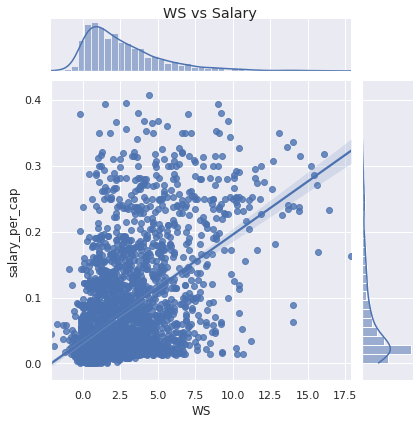

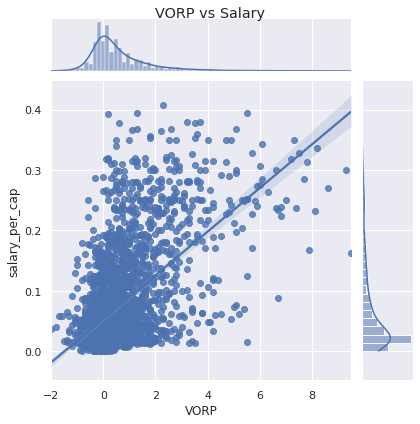

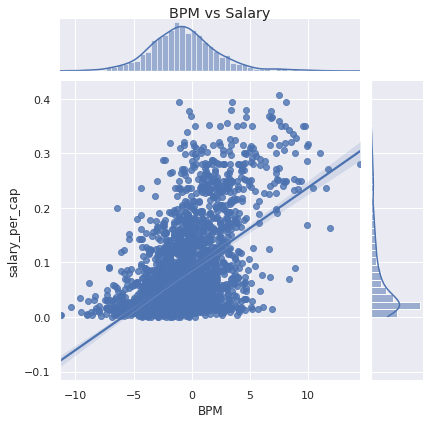

In [168]:
p = sns.jointplot(x='WS',y='salary_per_cap', kind="reg", data=df );
p.fig.suptitle("WS vs Salary")
p.fig.subplots_adjust(top=0.95)


p = sns.jointplot(x='VORP',y='salary_per_cap', kind="reg", data=df );
p.fig.suptitle("VORP vs Salary")
p.fig.subplots_adjust(top=0.95) 


p = sns.jointplot(x='BPM',y='salary_per_cap', kind="reg", data=df );
p.fig.suptitle("BPM vs Salary")
p.fig.subplots_adjust(top=0.95)

There are much stronger trends here for all of these stats with salary, which makes it seem that these impact stats are even more relevant in determining a player's salary. 

#### Creating our own metric

From the plots we made before, we can see that box score and impact stats are much more accurate measures of judging how much money a player should make. However, I think there's a way to use efficiency in a better way to give us a more accurate summary of how valauble a player is. 

First, I want to combine a player's scoring with their shooting percentages, and calculate the difference between their assits and turnovers. I'm also just going to add the defensive stats like rebounds, steals, and blocks to this.

Then, I want to combine the effect a player has when they're on the court and how they impact winning. So, I'm going to take the average of the player's Box Plus Minus and Value Over Replacement Player stats and multiply that by their winshares.

Im choosing to isolate these features because I want to see if a player's value really depends on if their team is winning a lot. Basically, I want to see how large the impact winning has on the metrics of how valuable a player is.

In [169]:
df['True_Value'] =  ((df['PTS'] * df['FG%'] * df['FT%']  + df['3P'] * df['3P%'])*df['PER'] + (df['AST'] - df['TOV']) + (df['TRB'] + df['STL'] + df['BLK']) + ((df['VORP'] + df['BPM']) / 2.0)) * df['WS']

Let's plot this stat vs salary from 2015-2022 to give use a better look at the correlation.

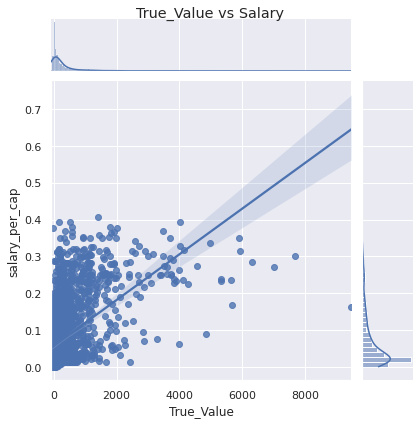

In [170]:
p = sns.jointplot(x='True_Value',y='salary_per_cap', kind="reg", data=df );
p.fig.suptitle("True_Value vs Salary")
p.fig.subplots_adjust(top=0.95)  

Let's see who's current at the top and bottom of this metric and review that against who's at the top of salary.

In [171]:
df_2021 = df[df['Year'] == '2022']
df_2021.sort_values(by=['True_Value'],ascending=False).head(10)

Player      Salary   salary_cap  salary_per_cap   Tm  \
21            Nikola Jokic  31579390.0  112414000.0        0.280920  DEN   
4             Kevin Durant  40918900.0  112414000.0        0.364002  BRK   
6    Giannis Antetokounmpo  39344900.0  112414000.0        0.350000  MIL   
0            Stephen Curry  45780966.0  112414000.0        0.407253  GSW   
134             Trae Young   8326471.0  112414000.0        0.074070  ATL   
13             Rudy Gobert  34844000.0  112414000.0        0.309961  UTA   
49           Jarrett Allen  20000000.0  112414000.0        0.177914  CLE   
19      Karl-Anthony Towns  31650600.0  112414000.0        0.281554  MIN   
37           DeMar DeRozan  26000000.0  112414000.0        0.231288  CHI   
8             Jimmy Butler  36016200.0  112414000.0        0.320389  MIA   

        G   PTS   TRB  AST  STL  ...    FG%    3P%    FT%   WS   BPM  VORP  \
21   24.0  26.3  13.5  7.5  1.3  ...  0.590  0.381  0.754  5.1  14.5   3.3   
4    27.0  29.7   7.9  5.9  0.6  ...  0.523  0.382  0.886  4.6   6.8   2.2   
6    26.0  27.0  11.6  5.8  1.1  ...  0.529  0.280  0.681  4.7   9.7   2.5   
0    28.0  27.0   5.5  6.1  1.6  ...  0.430  0.398  0.929  4.4   7.5   2.3   
134  29.0  27.3   4.0  9.3  1.0  ...  0.460  0.377  0.891  3.6   4.6   1.7   
13   29.0  15.1  14.8  1.0  0.8  ...  0.738  0.000  0.672  5.4   5.0   1.6   
49   28.0  16.8  10.8  2.0  0.9  ...  0.702  0.167  0.719  5.0   4.5   1.5   
19   28.0  24.4   9.0  3.4  1.1  ...  0.509  0.420  0.821  3.8   4.6   1.6   
37   24.0  26.4   5.3  4.1  0.9  ...  0.498  0.333  0.888  3.4   2.9   1.1   
8    18.0  22.8   5.8  5.2  2.2  ...  0.509  0.194  0.852  3.4   8.5   1.6   

       TS%   PER  Year   True_Value  
21   0.664  34.2  2022  2299.004090  
4    0.626  26.0  2022  1809.139941  
6    0.601  30.5  2022  1546.107542  
0    0.606  23.6  2022  1410.038978  
134  0.583  25.6  2022  1173.424308  
13   0.745  25.3  2022  1133.257122  
49   0.723  24.2  2022  1106.531406  
19   0.624  23.4  2022  1050.643393  
37   0.592  23.3  2022   982.355019  
8    0.607  26.9  2022   966.255648  

[10 rows x 23 columns]

In [172]:
df_2021.sort_values(by=['Salary'],ascending=False).head(10)

Player      Salary   salary_cap  salary_per_cap   Tm     G  \
0          Stephen Curry  45780966.0  112414000.0        0.407253  GSW  28.0   
1           James Harden  44310840.0  112414000.0        0.394175  BRK  26.0   
2      Russell Westbrook  44211146.0  112414000.0        0.393289  LAL  30.0   
3           LeBron James  41180544.0  112414000.0        0.366329  LAL  18.0   
4           Kevin Durant  40918900.0  112414000.0        0.364002  BRK  27.0   
5            Paul George  39344970.0  112414000.0        0.350001  LAC  24.0   
6  Giannis Antetokounmpo  39344900.0  112414000.0        0.350000  MIL  26.0   
7         Damian Lillard  39344900.0  112414000.0        0.350000  POR  24.0   
8           Jimmy Butler  36016200.0  112414000.0        0.320389  MIA  18.0   
9          Tobias Harris  35995950.0  112414000.0        0.320209  PHI  21.0   

    PTS   TRB  AST  STL  ...    FG%    3P%    FT%   WS  BPM  VORP    TS%  \
0  27.0   5.5  6.1  1.6  ...  0.430  0.398  0.929  4.4  7.5   2.3  0.606   
1  20.8   7.9  9.6  1.4  ...  0.404  0.337  0.885  2.9  3.5   1.3  0.582   
2  19.4   7.7  8.3  1.1  ...  0.452  0.319  0.671  1.5 -1.1   0.2  0.526   
3  25.7   6.2  6.8  1.7  ...  0.500  0.357  0.762  2.2  4.7   1.1  0.600   
4  29.7   7.9  5.9  0.6  ...  0.523  0.382  0.886  4.6  6.8   2.2  0.626   
5  25.0   7.3  5.4  1.9  ...  0.422  0.318  0.880  1.1  2.4   1.0  0.527   
6  27.0  11.6  5.8  1.1  ...  0.529  0.280  0.681  4.7  9.7   2.5  0.601   
7  22.8   4.2  7.7  0.6  ...  0.395  0.316  0.891  1.8  0.3   0.5  0.535   
8  22.8   5.8  5.2  2.2  ...  0.509  0.194  0.852  3.4  8.5   1.6  0.607   
9  18.5   7.7  3.4  0.3  ...  0.459  0.299  0.849  1.3 -0.7   0.2  0.540   

    PER  Year   True_Value  
0  23.6  2022  1410.038978  
1  20.0  2022   529.501256  
2  16.1  2022   169.864955  
3  22.8  2022   573.851608  
4  26.0  2022  1809.139941  
5  17.9  2022   213.347794  
6  30.5  2022  1546.107542  
7  18.8  2022   323.593533  
8  26.9  2022   966.255648  
9  17.2  2022   182.417347  

[10 rows x 23 columns]

Looking at this graph, we can see there is some correlation between salary and true value, as a lot of the players with low true values tend to have lower salaries, while most high paid players are higher in this. This makes sense as you would imagine that players that are deemed the most "valuable" would be paid accordingly. However, as we get the top of the list of player salaries, this trend starts to dip a bit as we can see that only 4 of the top 10 in salary are also in the top 10 of True Value.

I also considered the possibility that this stat still favored winning too heavily. Looking at the plot, most of the players with lower true values are on teams with relatively mediocre records and most of the higher true values were for players on better teams. However, Nikola Jokic is another outlier here. Currently as I'm writing this, his team is 12-12 and sits at 8th place in the Western Conference which would make them the last seed in the playoffs, yet he has the highest true value in the league.

This fact is inline with the results we found in the other comparisons where he led in both Box Plus Minus and Value over Replacement Player but was behind in Winshares. This could mean that he is **relatively** the most valuable player in the NBA but his teammates aren't playing well enough when he's substituted out, so his team is not winning enough games.

## 4. Machine Learning and Predictions

### 4.1 Data Preperation

In the last section we created visualizations of our data to get a better understanding of how salary relates to a stas like Box Plus Minus, Winshares, and Value over replacement player. We then came up with an effective metric that takes the aforementioned stats together to give us a better way of determining how valuable a player is.

The goal of this section is to create a machine learning model that can accurately predict how much a player's salary should be based on their value with brand new data.

First we need to import sklearn and some of it's libraries to ultimately create our model

In [173]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

We're also going to drop categorical columns from the dataset to not confuse it with non-numerical data.

In [174]:
d = df.drop(['Year', 'Player', 'Tm', 'salary_cap'], axis=1)
d = d._get_numeric_data()

Next, we'll assign the feature vector to be salary_per_cap. Again, we want to focus on this because we can more accurately train our data across the years as salary increased.

In [175]:
# Seperate and assign features and target columns
y = d['salary_per_cap']
X = d.drop('salary_per_cap', axis=1)
X.shape, y.shape

((2593, 18), (2593,))

Now we can make our training and testing data

In [176]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_train.shape, y_test.shape

((1555, 18), (1038,))

### 4.2 Model Building and Training

#### Linear Regression

Linear Regression is the simplest way of implementing regression for our dataset. It find the parameters that minimize the mean squared error between predictions and the true regression targets on the training data.

In [177]:
from sklearn.metrics import mean_squared_error
# instantiate our lr model
lr = LinearRegression()
# fit the model with our training data
lr.fit(X_train, y_train)

# predicting the target value from the model for the samples
y_test_lr = lr.predict(X_test)
y_train_lr = lr.predict(X_train)

# computing the accuracy of the model performance
acc_train_lr = lr.score(X_train, y_train)
acc_test_lr = lr.score(X_test, y_test)

# computing root mean squared error (RMSE)
rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_lr))
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_test_lr))

print("Accuracy on training Data: {:.3f}".format(acc_train_lr))
print("Accuracy on test Data: {:.3f}".format(acc_test_lr))
print('\nRMSE of training set:', rmse_train_lr)
print('RMSE of the testing set:', rmse_test_lr)

Accuracy on training Data: 0.954
Accuracy on test Data: 0.955

RMSE of training set: 0.017385368236054282
RMSE of the testing set: 0.017582301491630592


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.9542435638274911

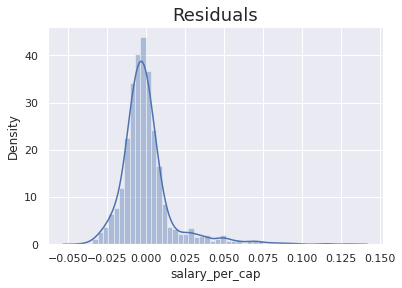

In [178]:
y_hat = lr.predict(X_train)
sns.distplot(y_train - y_hat)
plt.title("Residuals", size=18)
lr.score(X_train,y_train)

#### Let's Try it out!

First, let's get the stats for a player this season.

In [179]:
d = df[df['Year'] == '2021']
d = d.drop(['Year', 'Tm'], axis=1)

In [180]:
temp_player = d[d['Player'] == 'Nikola Jokic']
temp_player = temp_player._get_numeric_data()

In [181]:
temp_player.head()

Salary   salary_cap  salary_per_cap     G   PTS   TRB  AST  STL  BLK  \
23  29542010.0  109140000.0         0.27068  72.0  26.4  10.8  8.3  1.3  0.7   

    TOV   3P    FG%    3P%    FT%    WS   BPM  VORP    TS%   PER   True_Value  
23  3.1  1.3  0.566  0.388  0.868  15.6  11.7   8.6  0.647  31.3  7018.421594

Again, let's take a note of that salary_per_cap value of 0.407253. We'll compare this to our predicted value later.

In [182]:
acutal_per_cap = temp_player['salary_per_cap'].values[0]

In [183]:
temp_player = temp_player.drop(['salary_per_cap', 'salary_cap'], axis=1)
temp_player.shape

(1, 18)

In [184]:
predicted_per_cap = lr.predict(temp_player)[0]

In [185]:
print(predicted_per_cap)

0.2938463663420062


In [186]:
print(f'Actual Salary per cap: {acutal_per_cap}')
print(f'Predicted Salary per cap: {predicted_per_cap}')

Actual Salary per cap: 0.2706799523547737
Predicted Salary per cap: 0.2938463663420062


Not perfect, but pretty close!

### 5. Conclusion

This tutorial gave a great insight into how teams asses player value and which stats they look for in particular. Our results showed players who put up better offesnive stats like points and assits were generally more likely to get higher salaries compared to those who led in traditional defensive stats like rebounds, blocks, and steals. This is inline with what the NBA has turned into the past few years though. With the use of advanced data analytics, teams are valuing offenses more and more and the better offensive player you are, the more valuable you seem to teams. However, one constant that was pretty consistent was that high impact players also tended to get paid well. Again, this should make sense because these players are generally on winning teams who don't want to mess up the cohesion and chemistry of a team by not paying someone that may not put up great standard stats but has a big impact when on the court regardless. 

### 6. References

If you want to take a look at some of the resources I used for this tutorial, try some of these links:

- [Linear Regression](https://medium.com/data-science-group-iitr/linear-regression-back-to-basics-e4819829d78b)
- [Linear Regression with scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

- [Exploratory Data Analysis](https://towardsdatascience.com/exploratory-data-analysis-eda-a-practical-guide-and-template-for-structured-data-abfbf3ee3bd9)

The code for this project is available at this [GitHub repo](https://github.com/nishgowda/nba-salary-predictions)